# Analysis
The following includes examples on how to extract information from the generated results.  
It uses the latest 'pickle_all' file located in './results/run_*/pickles/'.  
The structure of the pickle is as follows:

```python
data:
    generations:
        [network, score]
```

To access the networks from the first generation:
```python
generation_0 = data[0]
```

To access the first network in that generation:
```python
network = generation_0[0][0]
score = generation_0[0][1]
```

A network has the following default structure (depended on the parameter constraints):
```python
{'network_config': {'n_layers': 2,
  'batch_size': 5000,
  'optimizer': 'adam',
  'epochs': 500},
 'layer_config': {'layer_type': ['dropout', 'dense'],
  'n_nodes': [32, 32],
  'activation': ['linear', 'relu'],
  'dropout': [0.2, 0.2]},
 'io_config': {'input_shape': 7,
  'inputs': ['end_Ca_end_angle',
   'psi',
   'OO_distance',
   'NCaR_angle',
   'the',
   'omega',
   'phi'],
  'output_shape': 24,
  'outputs': ['custom']}}
```


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
# Latest pickle_all file for all generations
log = './results/run_4/pickles/pickle_all-49'

with open(log, 'rb') as fp:
    full_data_pickle = pickle.load(fp)
    
def sort_key(arg):
    return arg[1]

top = 50
data = [sorted([x for x in full_data_pickle[gen]], key=sort_key)[:top] for gen in full_data_pickle]

scores = [sorted([x[1] for x in gen]) for gen in data]

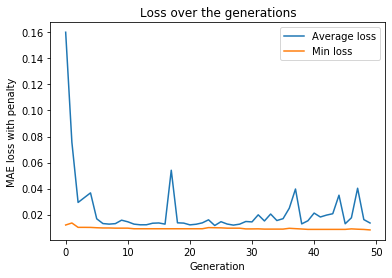

In [3]:
avg_points = [np.mean(x) for x in scores]
min_points = [np.min(x) for x in scores]
plt.plot(avg_points, label='Average loss')
plt.plot(min_points, label='Min loss')
plt.title('Loss over the generations')
plt.ylabel("MAE loss with penalty")
plt.xlabel("Generation")
plt.legend()
#plt.ylim(0, 0.015)
#plt.savefig('./figures/AD_CV_CT_loss.pdf', format='pdf')
plt.show()

In [7]:
data[49][0]

({'network_config': {'n_layers': 4,
   'batch_size': 5000,
   'optimizer': 'adam',
   'epochs': 500},
  'layer_config': {'layer_type': ['batch_norm', 'dropout', 'dense', 'dense'],
   'n_nodes': [64, 16, 8, 64],
   'activation': ['selu', 'linear', 'relu', 'relu'],
   'dropout': [0.2, 0.2, 0.2, 0.2]},
  'io_config': {'input_shape': 7,
   'inputs': ['the',
    'omega',
    'phi',
    'NCaR_angle',
    'OO_distance',
    'psi',
    'end_Ca_end_angle'],
   'outputs': ['custom'],
   'output_shape': 24}},
 0.008259983034804463,
 19)

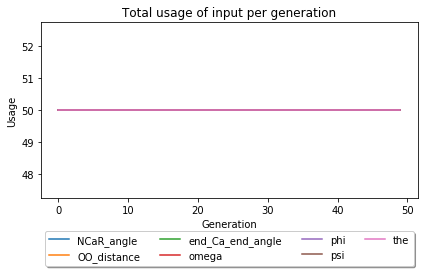

In [4]:
inputs = [[network[0]['io_config']['inputs'] for network in gen] for gen in data]
inputs_counts = [[Counter(x) for x in gen] for gen in inputs]
inputs_counts = [np.sum(gen) for gen in inputs_counts]

input_data = {}
all_inputs = []
for inputs in inputs_counts:
    for key in inputs.keys():
        all_inputs.append(key)
all_inputs = list(set(all_inputs))


for i, gen in enumerate(inputs_counts):
    for key in all_inputs:
        if i == 0:
            input_data[key] = []
        try:
            n_inputs = gen[key]
        except:
            n_inputs = 0
        input_data[key].append(gen[key])

fig, ax2 = plt.subplots()
ax2.set_ylabel('Usage') 
ax2.set_xlabel('Generation')
ax2.tick_params(axis='y')

for key in sorted(input_data.keys()):
    ax2.plot(input_data[key], label=key)

plt.title('Total usage of input per generation')
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), fancybox=True, shadow=True, ncol=4)
plt.tight_layout()
#plt.savefig('figures/AD_CV_CT_cvs.pdf', format='pdf')
plt.show()

In [5]:
def plot_stat_per_layer(data, stat):
    
    #get max number of layers
    n_layers_max = max([max([x[0]['network_config']['n_layers'] for x in gen]) for gen in data])
    
    #make dict containing all 'stat' for every layer per generation
    final = {}
    for layer in range(n_layers_max):
        final[layer] = {}
        for gen_id, gen in enumerate(data):
            final[layer][gen_id] = []
            for network in gen:
                try:
                    final[layer][gen_id].append((network[0]['layer_config'][stat])[layer])
                except IndexError:
                    pass
                
    #make counter of every gen per layer
    total = []
    for layer in range(n_layers_max):
        for gen_id, gen in enumerate(data):
            i_counter = Counter(final[layer][gen_id])
            final[layer][gen_id] = i_counter
            total.append(i_counter)
    
    layer_types = final

    #get all layer types:
    all_keys = np.sum(total).keys()

    #split into the different layers
    type_per_layer = {}
    for layer in range(n_layers_max):
        type_per_layer[layer] = {}
        for layer_type in all_keys:
            type_per_layer[layer][layer_type] = []
            for gen in layer_types[layer].keys():
                try:
                    type_per_layer[layer][layer_type].append(layer_types[layer][gen][layer_type])
                except:
                    type_per_layer[layer][layer_type].append(0)
    type_per_layer
    
    all_keys = sorted(all_keys)
    
    for layer in type_per_layer.keys():
        for key in all_keys:
            plt.plot(type_per_layer[layer][key], label=key)
        plt.title('Layer number: '+ str(layer))
        plt.legend()
        plt.show()

In [ ]:
#stats include everything in layer config so:
print("Available 'stats': " + str(list(data[0][0][0]['layer_config'].keys())))

plot_stat_per_layer(data, stat='activation')